In [1]:
import pickle
import pandas as pd
import os
from explainers.dce import DistributionalCounterfactualExplainer
import torch
from utils.visualization import *
from utils.data_processing import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec


pd.set_option('display.max_columns', None)

%reload_ext autoreload
%autoreload 2

c:\Users\leiyo\Anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
DEBUG:root:test


In [2]:
os.environ["PATH"] += os.pathsep + 'C:\\texlive\\2023\\bin\\windows'

In [3]:
data_path = 'data/german_credit'

In [4]:
df_ = pd.read_csv(os.path.join(data_path, 'german_credit_data.csv'))
df = df_.copy()

In [5]:
df.sample(5)

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
498,32,male,1,own,little,moderate,1301,18,radio/TV,good
52,25,male,2,own,little,NaN,1262,12,radio/TV,good
372,23,female,2,rent,little,NaN,2146,10,furniture/equipment,good
182,40,male,1,own,NaN,little,1647,21,car,bad
965,26,female,2,own,NaN,moderate,1715,30,radio/TV,good


In [6]:
df, label_mappings = feature_encoding(df=df, target_name='Risk', target_encode_dict={"good": 0, "bad": 1})

In [7]:
factual = pd.read_csv(os.path.join(data_path,'factual.csv'))
counterfactual = pd.read_csv(os.path.join(data_path,'counterfactual.csv'))

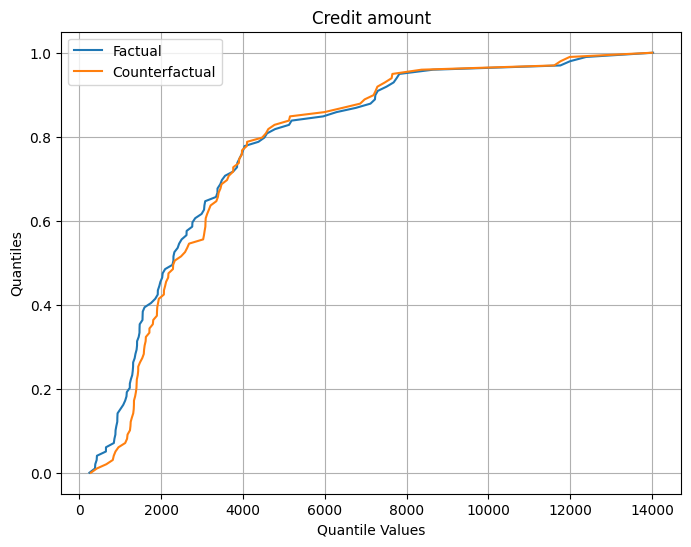

In [14]:
plot_quantile(factual=factual, counterfactual=counterfactual, column_name='Credit amount');

In [16]:
np.quantile(factual['Credit amount'], 0.4)

1691.8000000000002

In [25]:
factual.head(10)

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,39,male,2,own,little,Unknown,1473,18,radio/TV,0.072231
1,54,male,2,own,little,little,3051,48,domestic appliances,0.919690
2,27,male,2,own,quite rich,moderate,2326,15,business,0.062517
3,40,male,1,own,little,moderate,1155,12,radio/TV,0.086446
4,36,male,2,own,Unknown,Unknown,3079,36,car,0.153896
5,35,male,1,own,moderate,little,4380,18,car,0.063506
6,25,female,1,own,little,moderate,1355,24,car,0.818434
7,24,female,2,rent,little,little,652,12,furniture/equipment,0.782674
8,24,male,1,own,Unknown,little,3763,21,car,0.384604
9,32,male,2,rent,moderate,moderate,11760,39,education,0.934350


In [26]:
counterfactual.head(10)

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,39,male,2,own,little,Unknown,1442,17,radio/TV,0.024060
1,54,male,2,own,little,little,3029,48,domestic appliances,0.917797
2,27,male,2,own,quite rich,moderate,2586,14,business,0.036830
3,40,male,1,own,little,moderate,1385,10,radio/TV,0.047721
4,36,male,2,own,Unknown,Unknown,3169,36,car,0.021801
5,36,male,1,own,moderate,little,4472,17,car,0.023908
6,25,female,1,own,little,moderate,1332,24,car,0.817890
7,24,female,2,rent,little,little,662,12,furniture/equipment,0.781138
8,25,male,1,own,Unknown,little,4104,17,car,0.119727
9,32,male,2,rent,moderate,moderate,11766,39,education,0.935408


In [27]:
interval = (0, 25, 35, 65, 120)

cats = ['Student', 'Young', 'Adult', 'Senior']
df["Age_cat"] = pd.cut(df.Age, interval, labels=cats)

for cat in cats:
    risk_prob = df[df.Age_cat == cat]['Risk'].mean()
    print(f'Risk {cat}: {risk_prob}')

Risk Student: 0.42105263157894735
Risk Young: 0.2964824120603015
Risk Adult: 0.24619289340101522
Risk Senior: 0.2777777777777778


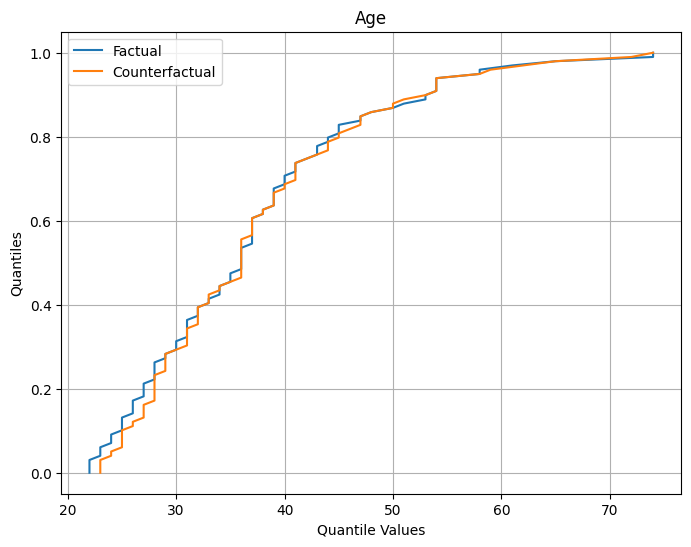

In [28]:
plot_quantile(factual=factual, counterfactual=counterfactual, column_name='Age');

In [29]:
factual['Risk'].mean(), counterfactual['Risk'].mean()

(0.3130257116629, 0.17500146086469998)

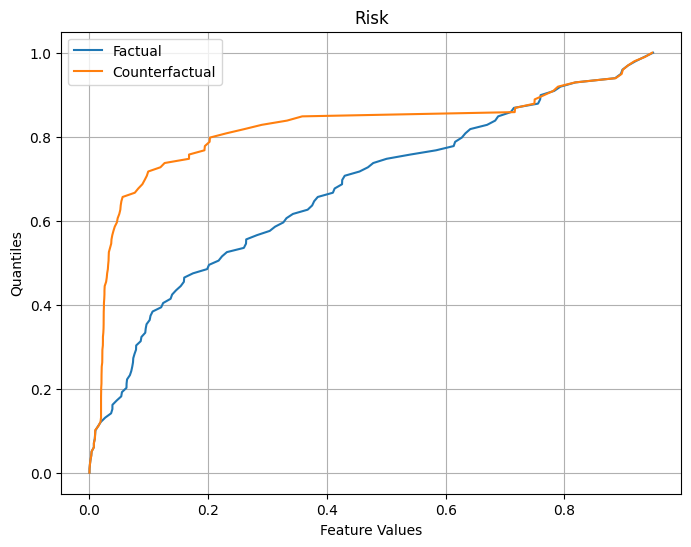

In [18]:
plot_quantile(factual=factual, counterfactual=counterfactual, column_name='Risk');

In [31]:
print('Risk Low credit amount:', df[df['Credit amount']<1000]['Risk'].mean())
print('Risk Middle credit amount:', df[ (df['Credit amount']>=1000) & (df['Credit amount']<=6000) ]['Risk'].mean())
print('Risk High credit amount:', df[df['Credit amount']>6000]['Risk'].mean())

Risk Low credit amount: 0.31896551724137934
Risk Middle credit amount: 0.2653061224489796
Risk High credit amount: 0.4563758389261745


In [36]:
factual['Risk'].mean(), counterfactual['Risk'].mean()

(0.3130257116629, 0.17500146086469998)

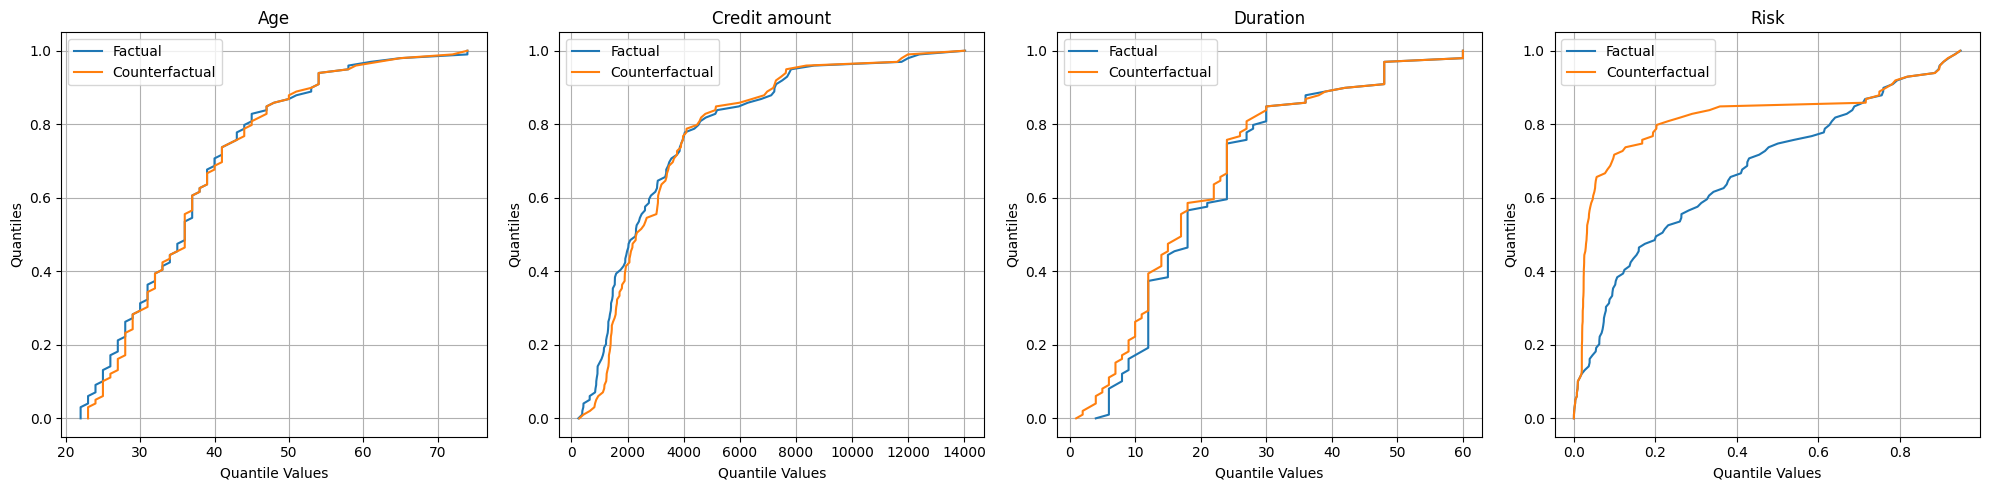

DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=20.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='c:\\Users\\leiyo\\Anaconda3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmr10.ttf', name='cmr10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='c:\\Users\\leiyo\\Anaconda3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXSizFiveSymReg.ttf', name='STIXSizeFiveSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='c:\\Users\\leiyo\\Anaconda3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmex10.ttf', name='cmex10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname

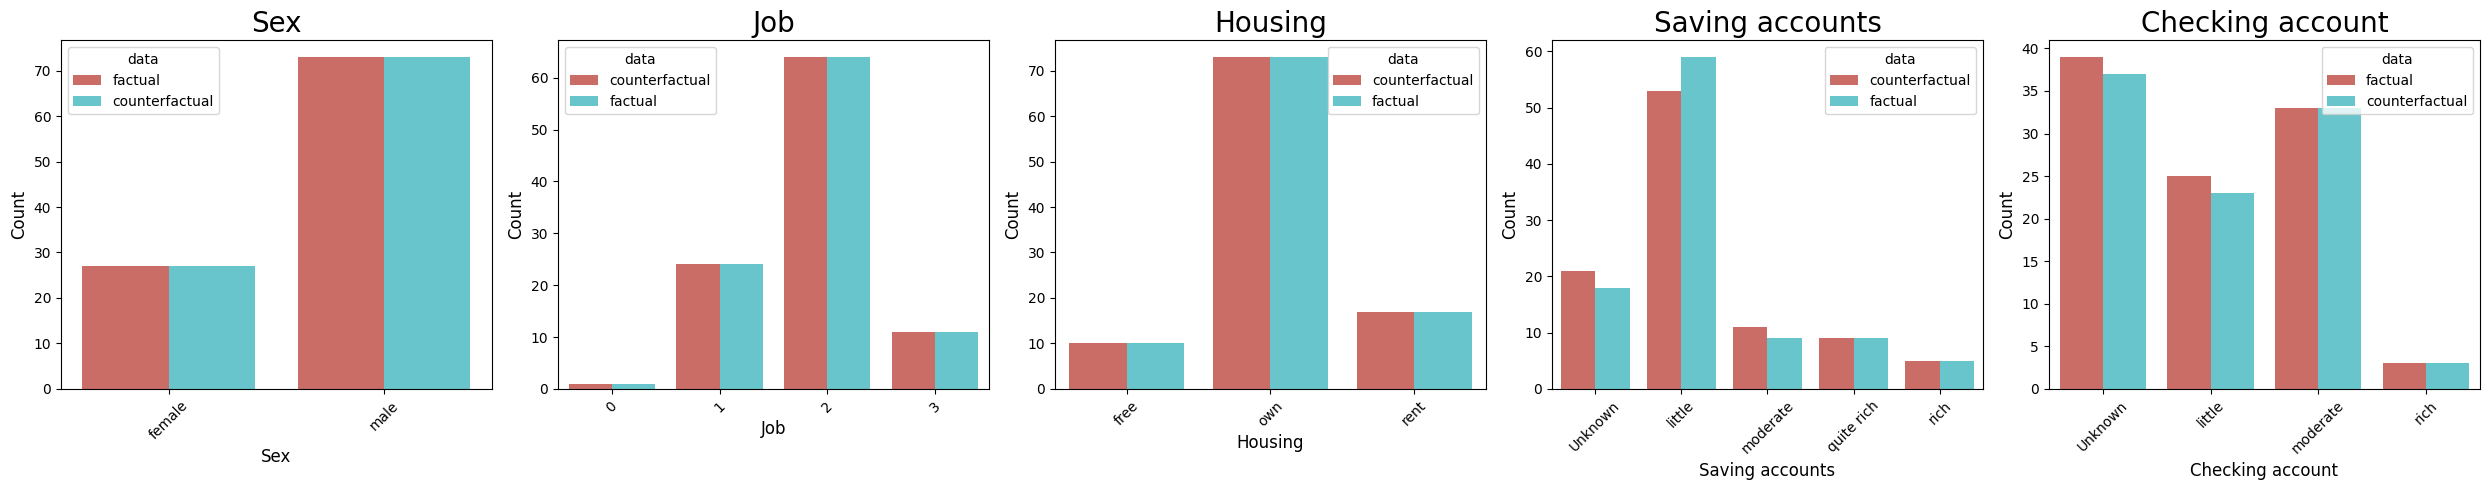

In [20]:
factual['data'] = 'factual'
counterfactual['data'] = 'counterfactual'

fcf = pd.concat([factual, counterfactual])

def plot_quantile_ax(factual, counterfactual, column_name):
    quantiles_factual = factual[column_name].quantile(np.linspace(0, 1, 100))
    quantiles_counterfactual = counterfactual[column_name].quantile(np.linspace(0, 1, 100))

    # Plot quantiles
    plt.plot(quantiles_factual.values, np.linspace(0, 1, 100), label="Factual")
    plt.plot(quantiles_counterfactual.values, np.linspace(0, 1, 100), label="Counterfactual")
    plt.xlabel("Quantile Values")
    plt.ylabel("Quantiles")
    plt.title(f"{column_name}")
    plt.legend()
    plt.grid(True)

# Assuming factual and counterfactual are pandas DataFrames with the same columns
columns = ['Age', 'Credit amount', 'Duration', 'Risk']

# Create a 3x4 subplot layout
plt.figure(figsize=(20, 5))
for i, column in enumerate(columns):
    plt.subplot(1, 4, i+1)
    plot_quantile_ax(factual, counterfactual, column)

plt.tight_layout()
plt.show()

def hist_plot_ax(df, x, hue, title, ax):
    g = sns.countplot(x=x, hue=hue, data=df.sort_values(by=x), palette="hls", ax=ax)
    g.set_xticklabels(g.get_xticklabels(), rotation=45)
    g.set_xlabel(x, fontsize=12)
    g.set_ylabel("Count", fontsize=12)
    g.set_title(title, fontsize=20)


columns = ['Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account']

factual['is_cf'] = False
counterfactual['is_cf'] = True

fcf = pd.concat([factual, counterfactual])

# Create a 3x4 subplot layout
plt.figure(figsize=(25, 5))
for i, column in enumerate(columns):
    ax = plt.subplot(1, 5, i+1)
    hist_plot_ax(fcf, column, 'data', column, ax)

plt.tight_layout()
plt.show()

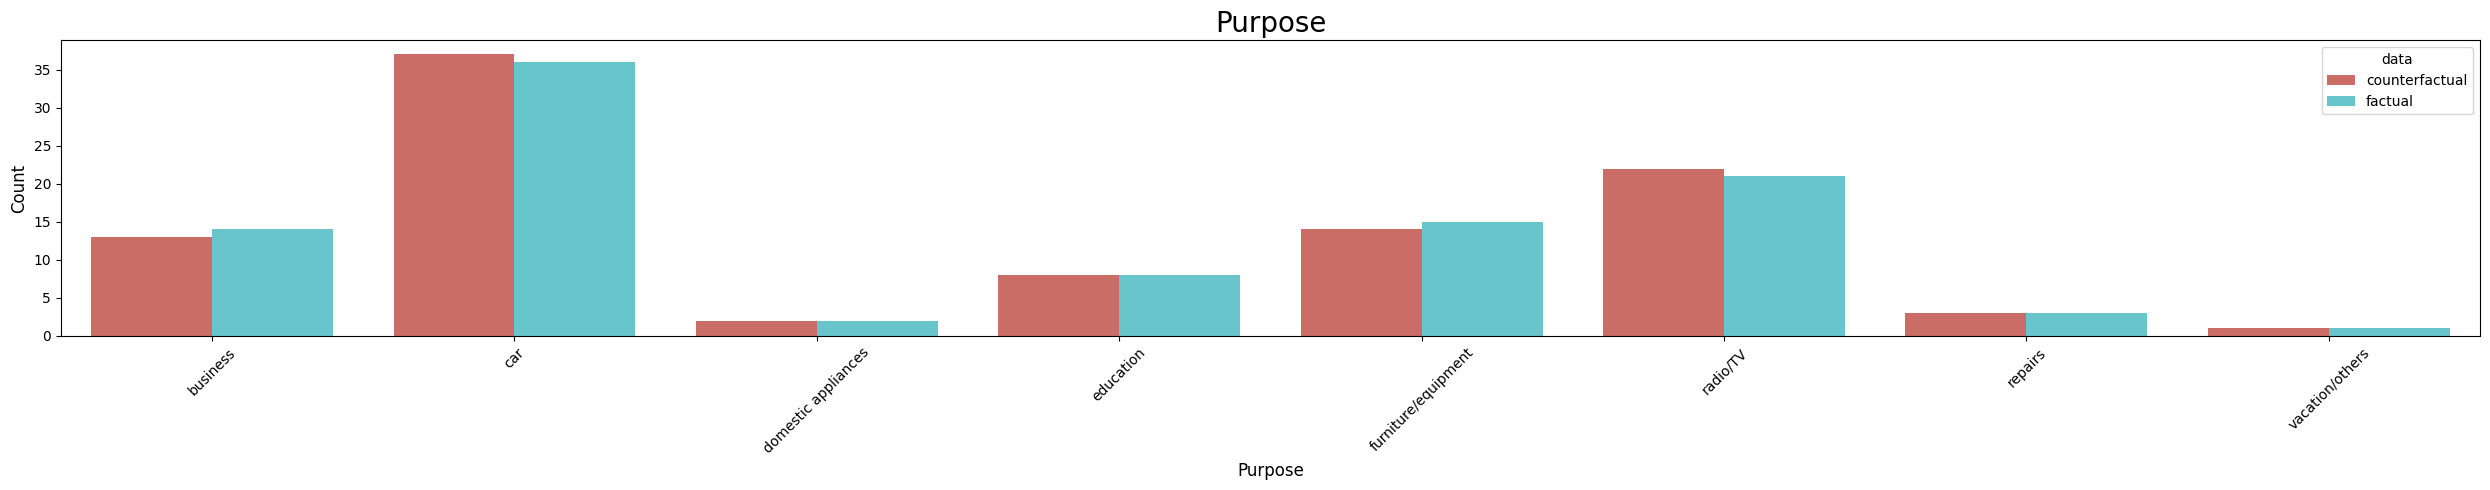

In [21]:
fig, ax = plt.subplots(figsize=(25,5))

hist_plot_ax(fcf, 'Purpose', 'data', 'Purpose', ax)

plt.tight_layout()
plt.show()

In [ ]:
column_name = 'Risk'
quantiles_factual = factual[column_name].quantile(np.linspace(0, 1, 100))
quantiles_counterfactual = counterfactual[column_name].quantile(np.linspace(0, 1, 100))

In [ ]:
s_factual = ""
for k, v in quantiles_factual.to_dict().items():
    s_factual += f" ({np.round(v,6)},{np.round(k,6)})"
print(s_factual)

In [24]:
s_counterfactual = ""
for k, v in quantiles_counterfactual.to_dict().items():
    s_counterfactual += f" ({np.round(v,6)},{np.round(k,6)})"
print(s_counterfactual)

 (0.000194,0.0) (0.000359,0.010101) (0.001015,0.020202) (0.001874,0.030303) (0.003196,0.040404) (0.003813,0.050505) (0.00761,0.060606) (0.007648,0.070707) (0.009343,0.080808) (0.009788,0.090909) (0.009795,0.10101) (0.015242,0.111111) (0.01882,0.121212) (0.019678,0.131313) (0.019688,0.141414) (0.019691,0.151515) (0.019695,0.161616) (0.019695,0.171717) (0.019704,0.181818) (0.019857,0.191919) (0.019948,0.20202) (0.020416,0.212121) (0.020465,0.222222) (0.02052,0.232323) (0.020699,0.242424) (0.020852,0.252525) (0.021711,0.262626) (0.021801,0.272727) (0.02187,0.282828) (0.021971,0.292929) (0.022751,0.30303) (0.022872,0.313131) (0.022872,0.323232) (0.023535,0.333333) (0.023908,0.343434) (0.02406,0.353535) (0.024105,0.363636) (0.024169,0.373737) (0.024231,0.383838) (0.024532,0.393939) (0.024567,0.40404) (0.025099,0.414141) (0.025427,0.424242) (0.025477,0.434343) (0.025858,0.444444) (0.028255,0.454545) (0.029312,0.464646) (0.029968,0.474747) (0.031175,0.484848) (0.031666,0.494949) (0.032357,0.5

In [25]:
column_name = 'Purpose'
factual[column_name].value_counts()

Purpose
car                    36
radio/TV               21
furniture/equipment    15
business               14
education               8
repairs                 3
domestic appliances     2
vacation/others         1
Name: count, dtype: int64

In [26]:
counterfactual[column_name].value_counts()

Purpose
car                    37
radio/TV               22
furniture/equipment    14
business               13
education               8
repairs                 3
domestic appliances     2
vacation/others         1
Name: count, dtype: int64

In [28]:
column_name = 'Purpose'
pd.concat(
    [
        pd.DataFrame(factual.groupby(column_name)['Risk'].mean()).rename({'Risk': 'Risk_factual'}, axis=1),
        pd.DataFrame(counterfactual.groupby(column_name)['Risk'].mean()).rename({'Risk': 'Risk_counterfactual'}, axis=1)
    ],
    axis=1,
)

,Risk_factual,Risk_counterfactual
Purpose,,
business,0.352393,0.204062
car,0.330718,0.156633
domestic appliances,0.461446,0.460496
education,0.329091,0.166482
furniture/equipment,0.278134,0.140084
radio/TV,0.272038,0.175539
repairs,0.327961,0.318689
vacation/others,0.038896,0.019948


In [29]:
column_name = 'Saving accounts'
indice = factual[(factual[column_name] != counterfactual[column_name])].index

factual.loc[indice]


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk,data,is_cf
10,43,male,2,rent,little,little,2625,16,car,0.500605,factual,False
24,31,female,2,own,little,little,1957,6,radio/TV,0.303706,factual,False
37,53,male,2,free,little,little,7119,48,furniture/equipment,0.469166,factual,False
54,45,male,1,own,little,little,4006,28,car,0.683338,factual,False
55,40,male,2,rent,Unknown,Unknown,7824,28,car,0.331893,factual,False
78,42,male,2,free,little,moderate,6288,60,education,0.413037,factual,False
82,34,male,2,own,little,little,3965,42,radio/TV,0.429980,factual,False


In [30]:
counterfactual.loc[indice]

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk,data,is_cf
10,45,male,2,rent,moderate,little,2489,10,car,0.025858,counterfactual,True
24,33,female,2,own,Unknown,little,2684,3,radio/TV,0.032357,counterfactual,True
37,51,male,2,free,Unknown,little,6976,48,radio/TV,0.032866,counterfactual,True
54,47,male,1,own,moderate,Unknown,4563,22,car,0.025099,counterfactual,True
55,41,male,2,rent,NaN,Unknown,7472,27,car,0.024567,counterfactual,True
78,41,male,2,free,Unknown,moderate,5993,60,education,0.040573,counterfactual,True
82,33,male,2,own,Unknown,little,3613,42,radio/TV,0.031666,counterfactual,True


DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x00000208A539B490>
DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x00000208A53856D0>


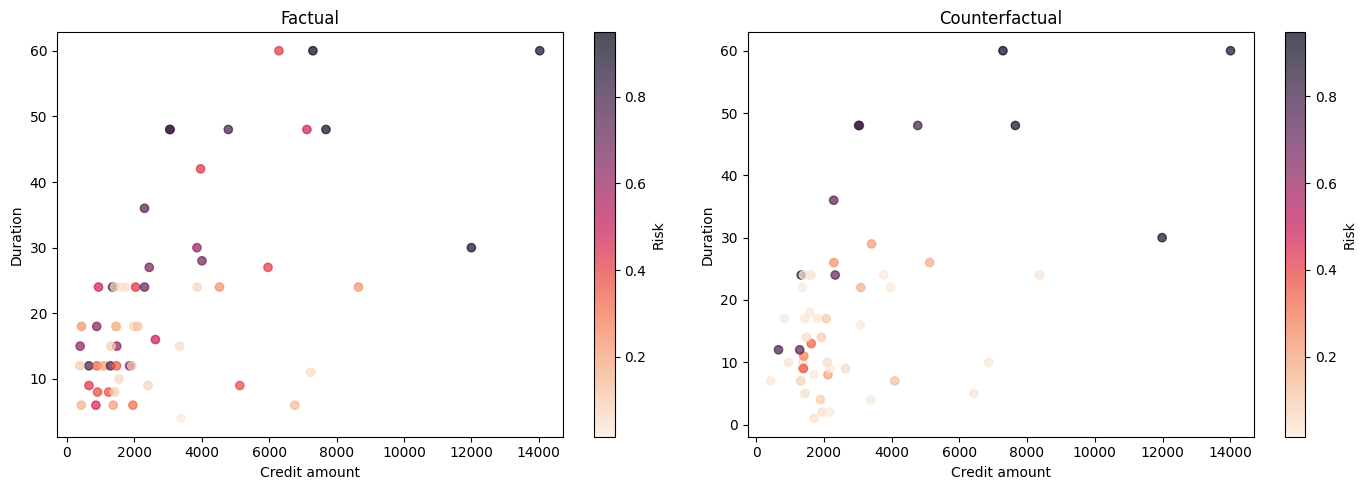

In [31]:
def colorful_scatter(df, x, y, color_col, title, ax):
    scatter = ax.scatter(df[x], df[y], alpha=0.7, c=df[color_col], cmap='rocket_r')

    # Adding colorbar to show the scale
    plt.colorbar(scatter, ax=ax, label=color_col)

    # Adding labels and title
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_title(title)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))  # Create 1 row, 2 columns of subplots

# Assuming 'df' is your DataFrame and it already contains the columns 'Credit amount', 'Duration', and 'Risk'
# Call the function with the respective axes object
colorful_scatter(factual[factual['Saving accounts']=='little'], 'Credit amount', 'Duration', 'Risk', 'Factual', ax1)
colorful_scatter(counterfactual[counterfactual['Saving accounts']=='little'], 'Credit amount', 'Duration', 'Risk', 'Counterfactual', ax2)

plt.tight_layout()  # Adjust the layout
plt.show()

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x00000208AC23A940>
DEBUG:matplotlib.texmanager:family: serif, font: Times, info: \usepackage{mathptmx}
DEBUG:matplotlib.texmanager:DejaVu Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Sans font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: sans-serif, font: Computer Modern Sans Serif, info: \usepackage{type1ec}
DEBUG:matplotlib.texmanager:Apple Chancery font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Textile font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: cursive, font: Zapf Chancery, info: \usepackage{chancery}
DEBUG:matplotlib.texmanager:DejaVu Sans Mono font is not compatible with usetex.
DEBUG:matplotlib.texmanager:Bitstream Vera Sans Mono font is not compatible with usetex.
DEBUG:matplotlib.texmanager:family: monospace, font: Computer Modern Typewriter, info: \usepackage{type1ec}
DEBUG:matplotlib.dviread:Dvi

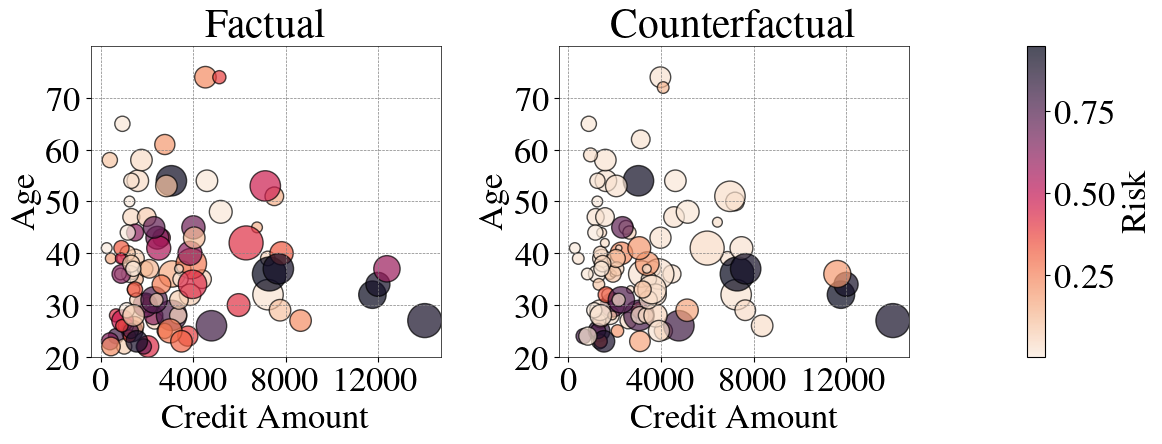

In [39]:
fontsize = 25

# Enable LaTeX text rendering in Matplotlib
plt.rcParams.update({
    "text.usetex": True,
    "text.latex.preamble": r"\usepackage{times}",  # Ensure you use the times package
    "font.family": "serif",
    "font.serif": ["Times", "Times New Roman"],  # This should use Times font
    "font.size": fontsize
})

def colorful_scatter_with_sizing(df, x, y, size_col, color_col, title, ax, show_colorbar=True, cbar_ax=None):
    scatter = ax.scatter(df[x], df[y], s=df[size_col]*10, alpha=0.7, c=df[color_col], cmap='rocket_r', edgecolor='black')

    # Adding colorbar conditionally
    if show_colorbar and cbar_ax is not None:
        cbar = plt.colorbar(scatter, cax=cbar_ax, label=color_col)
        cbar.ax.tick_params(labelsize=fontsize)  # Adjust for LaTeX

    # Adding labels and title
    ax.set_xlabel('Credit Amount')
    ax.set_ylabel(y)
    ax.set_title(title)
    ax.tick_params(axis='both', which='major', labelsize=fontsize)

    # Set grid interval
    ax.set_xticks(np.arange(0, 15000, 4000))  # Set x grid interval
    ax.set_yticks(np.arange(20, 80, 10))  # Set y grid interval

    ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')  # Grid lines like TikZ
    ax.set_facecolor('white')  # White background like TikZ
    ax.set_ylim(20, 80)

    # Make sure the spines (frame) are visible
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_color('black')
        spine.set_linewidth(0.5)

# Create a GridSpec with 2 columns with the second column being slightly narrower for the colorbar
fig = plt.figure(figsize=(12, 5))
gs = GridSpec(1, 3, width_ratios=[1, 1, 0.05])

# Create the two subplots and the colorbar axis
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
cbar_ax = fig.add_subplot(gs[2])

# Call the function with the axes object
colorful_scatter_with_sizing(factual, 'Credit amount', 'Age', 'Duration', 'Risk', 'Factual', ax1, show_colorbar=False)
colorful_scatter_with_sizing(counterfactual, 'Credit amount', 'Age', 'Duration', 'Risk', 'Counterfactual', ax2, cbar_ax=cbar_ax)

# Adjust the layout so there's no extra space
plt.tight_layout()

# Save the figure as a PDF
plt.savefig('pictures/german_credit_scatter.pdf', format='pdf', bbox_inches='tight')

# Display the plot
plt.show()

# Make sure to close the figure after saving to avoid memory issues
plt.close(fig)



In [225]:
factual.groupby('Saving accounts')['Risk'].mean()

Saving accounts
Unknown       0.167109
little        0.395192
moderate      0.504113
quite rich    0.025870
rich          0.041689
Name: Risk, dtype: float64

In [226]:
counterfactual.groupby('Saving accounts')['Risk'].mean()

Saving accounts
Unknown       0.042100
little        0.248309
moderate      0.295145
quite rich    0.011064
rich          0.016987
Name: Risk, dtype: float64

In [37]:
with open(os.path.join(data_path, 'explainer.pkl'), 'rb') as file:
    explainer = pickle.load(file)

In [7]:
col_names = []
col_scores = []
for column, col_index in zip(explainer.explain_columns, explainer.explain_indices):

    y_s = torch.FloatTensor(explainer.X[:, col_index])
    y_t = torch.FloatTensor(explainer.X_prime[:, col_index])
    wd_dist, _ = explainer.wd.distance(y_s, y_t, delta=0)

    col_names.append(column)
    col_scores.append(wd_dist.item())

pd.DataFrame({
    'Feature': col_names,
    'Score': col_scores,
}).sort_values(by='Score', ascending=False)

,Feature,Score
4,Saving accounts,0.068774
5,Checking account,0.060398
7,Duration,0.018836
3,Housing,0.010426
8,Purpose,0.010098
1,Sex,0.008110
6,Credit amount,0.007604
2,Job,0.007195
0,Age,0.004521


In [ ]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(explainer.X_prime.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);
# save heatmap as .png file
# dpi - sets the resolution of the saved image in dots/inches
# bbox_inches - when set to 'tight' - does not allow the labels to be cropped
# plt.savefig('heatmap.png', dpi=300, bbox_inches='tight')

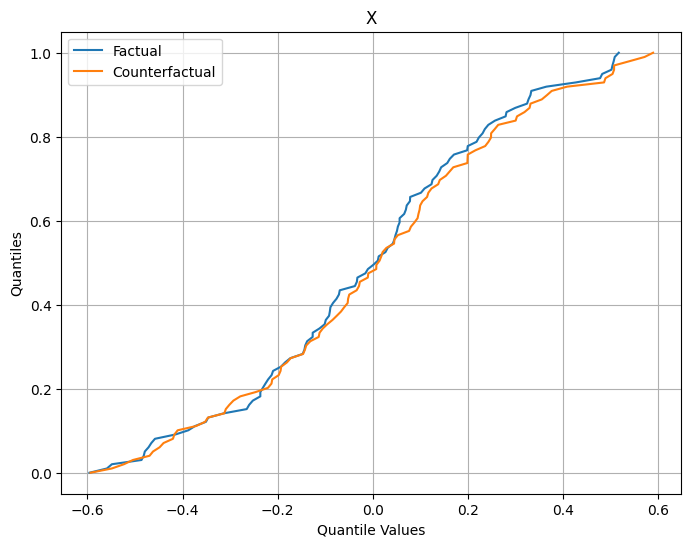

In [8]:

fa = torch.zeros_like(explainer.X_prime[:, explainer.explain_indices] @ explainer.swd.thetas[0])
dfa = torch.zeros_like(explainer.X_prime[:, explainer.explain_indices] @ explainer.swd.thetas[0])
for theta in explainer.swd.thetas:

    fa += explainer.X_prime[:, explainer.explain_indices] @ theta
    dfa += explainer.best_X[:, explainer.explain_indices] @ theta
    
fa /= len(explainer.swd.thetas)
dfa /= len(explainer.swd.thetas)

plot_quantile(factual=pd.DataFrame({'X': fa}), counterfactual=pd.DataFrame({'X': dfa}), column_name='X')

In [15]:
s_factual = ""
s_counterfactual = ""

for k, v in enumerate(np.sort(fa.numpy())):
    s_factual += f" ({np.round(v,6)},{np.round(k/100,6)})"

for k, v in enumerate(np.sort(dfa.numpy())):
    s_counterfactual += f" ({np.round(v,6)},{np.round(k/100,6)})"

print(s_factual)
print(s_counterfactual)

 (-0.595756,0.0) (-0.55905,0.01) (-0.548583,0.02) (-0.48635,0.03) (-0.48161,0.04) (-0.47934,0.05) (-0.471447,0.06) (-0.465658,0.07) (-0.457966,0.08) (-0.415545,0.09) (-0.387872,0.1) (-0.373835,0.11) (-0.350797,0.12) (-0.346036,0.13) (-0.3133,0.14) (-0.26506,0.15) (-0.259927,0.16) (-0.252193,0.17) (-0.23644,0.18) (-0.23642,0.19) (-0.231177,0.2) (-0.225758,0.21) (-0.220038,0.22) (-0.212794,0.23) (-0.209641,0.24) (-0.193021,0.25) (-0.184359,0.26) (-0.173397,0.27) (-0.147337,0.28) (-0.143707,0.29) (-0.141965,0.3) (-0.137977,0.31) (-0.12641,0.32) (-0.126296,0.33) (-0.112107,0.34) (-0.101129,0.35) (-0.098822,0.36) (-0.09189,0.37) (-0.090265,0.38) (-0.089068,0.39) (-0.083623,0.4) (-0.076271,0.41) (-0.071167,0.42) (-0.069393,0.43) (-0.037524,0.44) (-0.033449,0.45) (-0.03231,0.46) (-0.015558,0.47) (-0.010255,0.48) (0.001133,0.49) (0.010666,0.5) (0.012436,0.51) (0.026676,0.52) (0.031346,0.53) (0.042217,0.54) (0.045505,0.55) (0.047831,0.56) (0.050908,0.57) (0.052759,0.58) (0.056428,0.59) (0.05644

In [9]:
fa

tensor([-0.0836, -0.1420, -0.3879,  0.0528,  0.0107, -0.0763,  0.1985,  0.5041,
         0.1708,  0.2182,  0.3334, -0.1264,  0.3316,  0.0564,  0.4272, -0.1380,
         0.3245,  0.5173, -0.0334, -0.4714, -0.1930, -0.0891,  0.0455,  0.1438,
         0.1621, -0.5486,  0.4781,  0.0267,  0.2357,  0.0313,  0.1089,  0.0714,
        -0.4155, -0.3738, -0.1011, -0.2364,  0.1256, -0.4793,  0.2310,  0.0696,
        -0.0103, -0.0712,  0.1398, -0.2312,  0.5067, -0.0988, -0.2200, -0.0694,
        -0.1734, -0.4580, -0.0156,  0.0124, -0.4657,  0.2794,  0.0478,  0.5088,
        -0.1473,  0.2812,  0.2230,  0.0564, -0.3460,  0.0509, -0.4863,  0.1567,
        -0.0323, -0.3133,  0.3275,  0.1235,  0.0011, -0.2258, -0.2599, -0.5958,
         0.0661,  0.0787,  0.2430, -0.1121,  0.0782, -0.0919, -0.5591,  0.1013,
         0.1998,  0.0422, -0.1437, -0.1844,  0.4825, -0.2651,  0.3650, -0.2128,
        -0.0903, -0.1263, -0.2364, -0.0375, -0.2522,  0.2997, -0.4816, -0.2096,
        -0.3508,  0.1344,  0.5020,  0.25

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x0000019A67901BB0>


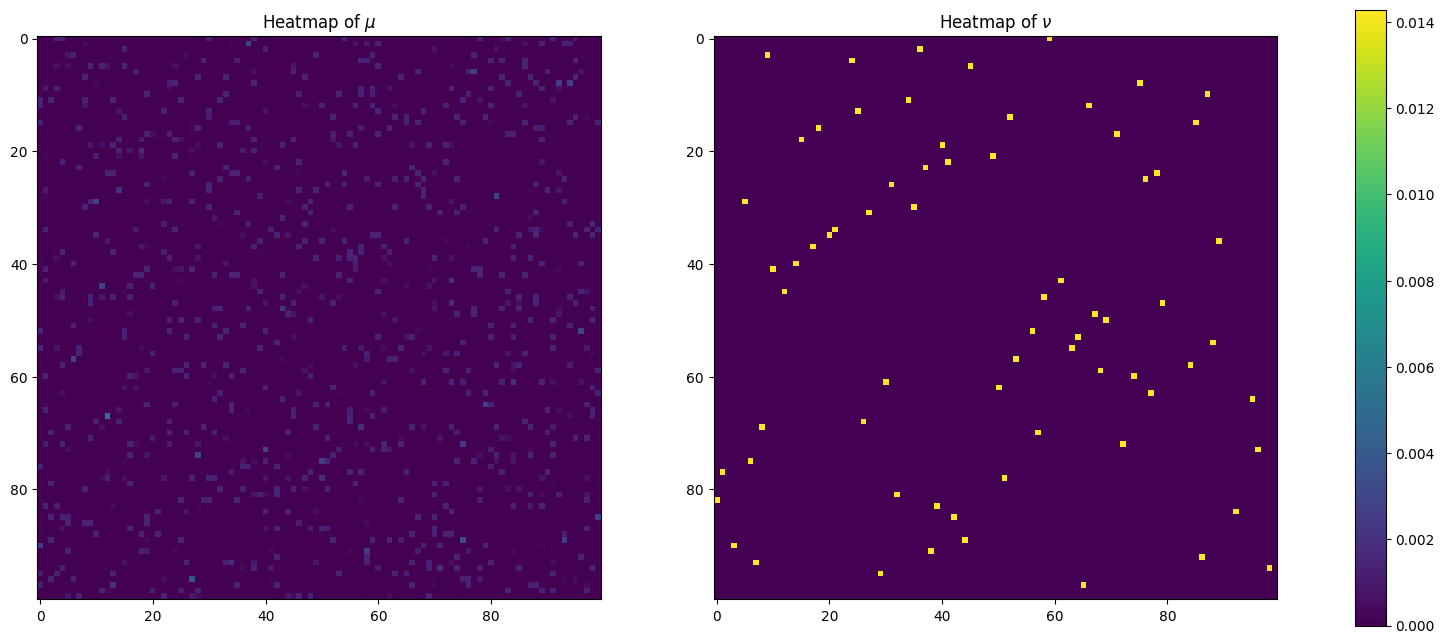

In [48]:
matrix_nu = explainer.wd.nu.detach().numpy()

mu_avg = torch.zeros_like(explainer.swd.mu_list[0])
for mu in explainer.swd.mu_list:
    mu_avg += mu

total_sum = mu_avg.sum()

matrix_mu = mu_avg / total_sum

# Determine the global minimum and maximum values across both matrices
vmin = min(matrix_mu.min(), matrix_nu.min())
vmax = max(matrix_mu.max(), matrix_nu.max())

# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 2, figsize=(20, 8))  # 1 row, 2 columns

# First subplot for matrix_mu
im_mu = axs[0].imshow(matrix_mu, cmap='viridis', vmin=vmin, vmax=vmax)
axs[0].set_title("Heatmap of $\mu$")

# Second subplot for matrix_nu
im_nu = axs[1].imshow(matrix_nu, cmap='viridis', vmin=vmin, vmax=vmax)
axs[1].set_title("Heatmap of $\\nu$")

# Create a colorbar for the whole figure
fig.colorbar(im_mu, ax=axs, orientation='vertical')

# Display the plots
plt.show()

In [27]:
row_num  = 16

# Interleave rows
combined = pd.concat([factual.head(row_num), counterfactual.head(row_num)]).sort_index(kind='merge')

# Define formatters for specific columns
formatters = {
    "Risk": lambda x: f"{x:.4f}"
}


# Convert to LaTeX
latex_code = combined.to_latex(index=False, formatters=formatters, 
                               caption="[\\textit{{German-Credit}}] Data points of factual and counterfactual distributions.", label="tab:german-credit")

print(latex_code)

\begin{table}
\caption{[\textit{{German-Credit}}] Data points of factual and counterfactual distributions.}
\label{tab:german-credit}
\begin{tabular}{rlrlllrrlr}
\toprule
Age & Sex & Job & Housing & Saving accounts & Checking account & Credit amount & Duration & Purpose & Risk \\
\midrule
39 & male & 2 & own & little & Unknown & 1473 & 18 & radio/TV & 0.0722 \\
39 & male & 2 & own & little & Unknown & 1442 & 17 & radio/TV & 0.0241 \\
54 & male & 2 & own & little & little & 3051 & 48 & domestic appliances & 0.9197 \\
54 & male & 2 & own & little & little & 3029 & 48 & domestic appliances & 0.9178 \\
27 & male & 2 & own & quite rich & moderate & 2326 & 15 & business & 0.0625 \\
27 & male & 2 & own & quite rich & moderate & 2586 & 14 & business & 0.0368 \\
40 & male & 1 & own & little & moderate & 1155 & 12 & radio/TV & 0.0864 \\
40 & male & 1 & own & little & moderate & 1385 & 10 & radio/TV & 0.0477 \\
36 & male & 2 & own & Unknown & Unknown & 3079 & 36 & car & 0.1539 \\
36 & male & 2 & 